# IRM news popularity

IRM is a compelling idea, bringing invariant causal prediction further into the world of machine learning. However, the results demonstrated in the paper are produced on datasets constructed for the purpose. Let's try it on a real problem.

To use IRM, we need to be able to construct datasets from different environments. The paper seems not to be very explicit about it, but I think the environments need the same thing as in the case of the Peters et al Invariant Causal Prediction paper - they should be constructed by "interventions" (really here just selection) on something that is not a direct cause of the outcome.

This [online news popularity](https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity) dataset seems to follow that form. There are many engineered features (typical for ML), which are all potential direct causes of article popularity (measured by number of shares). Also recorded are the number of days that have passed since the article was released (at time of collection). We'd expect, after an initial period, that this does not effect the number of shares, and as such, we can construct environments by splitting on it.

## Imports

In [1]:
import pandas as pd

import torch
from torch.autograd import grad

## Read data

In [2]:
df = pd.read_csv('../../data/OnlineNewsPopularity/OnlineNewsPopularity.csv')
df.columns = df.columns.map(str.strip) # remove leading spaces from column names

## Split data into environments

We'll split on the number of days since release, which covers almost two years. We can experiment with how many environments we create.

min timedelta:  8.0
max timedelta:  731.0


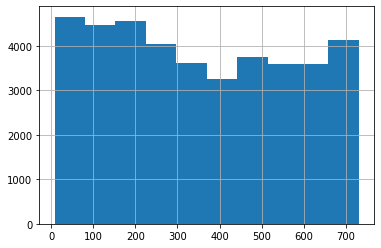

In [3]:
print('min timedelta: ', df.timedelta.min())
print('max timedelta: ', df.timedelta.max())
df.timedelta.hist()

In [4]:
environment_1_df = df[df.timedelta < 180]
environment_2_df = df[(df.timedelta >= 180) & (df.timedelta < 360)]
environment_3_df = df[(df.timedelta >= 360) & (df.timedelta < 540)]
environment_4_df = df[(df.timedelta >= 540)]

Are our environments about equally sized?

In [5]:
[x for x in map(len, [environment_1_df, environment_2_df, environment_3_df, environment_4_df])]

[10866, 9993, 8690, 10095]

Close enough.

## IRM on two environments

We'll first perform IRM on two environments to arrive an invariant representation. We'll then test the performance of the IRM representation vs a non-IRM learned version on the two holdout environments.

In [6]:
def df_to_tensors(df):
    features = torch.tensor(
        df.drop(['url','timedelta','shares'],
                axis='columns')
          .to_numpy()
    ).double()
    
    target = torch.tensor(
        df['shares'].to_numpy()
    ).unsqueeze(1).double()
    
    return (features, target)

In [7]:
env_1_tensors = df_to_tensors(environment_1_df)
env_2_tensors = df_to_tensors(environment_2_df)
env_3_tensors = df_to_tensors(environment_3_df)
env_4_tensors = df_to_tensors(environment_4_df)

In [8]:
n_features = env_1_tensors[0].shape[1]

In [9]:
train_environments = [env_1_tensors, env_2_tensors]
holdout_environments = [env_3_tensors, env_4_tensors]

In [10]:
# split into two random mini-batches of size b (random happens in the iteration)
# an unbiased estimate of the squared gradient norm

def compute_penalty(losses, dummy_w):
    g1 = grad(losses[0::2].mean(), dummy_w, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy_w, create_graph=True)[0]
    return (g1 * g2).sum()

In [11]:
phi = torch.nn.Parameter(torch.ones(n_features, 1).double())
dummy_w = torch.nn.Parameter(torch.Tensor([1.0])).double() # a dummy predictor

In [12]:
opt = torch.optim.Adam([phi], lr=1e-3)
mse = torch.nn.MSELoss(reduction="none")

We could probably speed up training by scaling (min-max or z-score) the input features.

In [ ]:
for iteration in range(50000):
    error = 0
    penalty = 0
    for x_e, y_e in train_environments:
        # here we permute data so that we get random minibatches when we compute the penalty.
        # this gives us an unbiased estimate for the squared gradient norm.
        p = torch.randperm(len(x_e))
        error_e = mse(x_e[p] @ phi * dummy_w, y_e[p])
        penalty += compute_penalty(error_e, dummy_w)
        error += error_e.mean()
        
    opt.zero_grad()
    (1e-5 * error + penalty).backward()
    opt.step()
    
    if iteration % 1000 == 0:
        print('error: ', error.item())
    if iteration % 10000 == 0:
        print('iteration: ', iteration)
        print('phi: ', phi.squeeze())

error:  2948864251254.466
iteration:  0
phi:  tensor([0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 1.0010,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 1.0010, 1.0010, 1.0010,
        0.9990, 0.9990, 0.9990, 0.9990], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)
error:  612255738908.9043
error:  228216353334.26666
error:  107815745656.4092
error:  56882808376.14217
error:  31788232439.29389
error:  18342502605.415916
error:  10785680851.320368
error:  6420548015.014734
error:  3859962728.7640095
error:  2345833811.3979073
iteration:  10000
phi:  tensor([0.0298, 0.0298, 0.0299, 0.0299, 0.0298, 0.0303, 0.0299, 0.0307, 0.0302,
        

In [ ]:
pred_env_1 = (env_1_tensors[0] @ phi).squeeze()

In [ ]:
(pd.DataFrame(
    {'predictions': pred_env_1.tolist(),
     'truth': env_1_tensors[1].squeeze().tolist()})
 .plot(x='truth', y='predictions',
       kind='scatter',
       alpha=0.2))

# Result

Clearly, we can't fit this dataset well with linear regression. In fact, the results are pretty poor. Fortunately, IRM works in nonlinear settings, but this requires some more work.

In [ ]:
(len(df), len(df[df.shares < 1500])) # -> 1500 shares is approximately half the dataset